In [1]:
!pip install yfinance pandas numpy matplotlib seaborn scikit-learn plotly

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")
print("Starting Data Pipeline & Feature Engineering Process...")


Libraries imported successfully!
Starting Data Pipeline & Feature Engineering Process...


In [3]:
## 1. DATA COLLECTION
print("\n" + "="*50)
print("STEP 1: DATA COLLECTION")
print("="*50)


assets = ['AAPL', 'MSFT', 'GOOGL', 'TSLA']
print(f"Fetching data for assets: {assets}")

# Function to fetch data
def fetch_data(symbols, period='6y'):
    """
    Fetch historical OHLCV data for multiple stock assets
    Ensures 6 years of data for all stocks
    """
    data = {}
    for symbol in symbols:
        try:
            ticker = yf.Ticker(symbol)
            df = ticker.history(period=period)
            if not df.empty and len(df) >= 1500:  # Approx 6 years of trading days
                data[symbol] = df
                print(f"✓ Successfully fetched {len(df)} records for {symbol}")
                print(f"  Date range: {df.index[0].strftime('%Y-%m-%d')} to {df.index[-1].strftime('%Y-%m-%d')}")
            else:
                print(f"✗ Insufficient data for {symbol} (need 6 years)")
        except Exception as e:
            print(f"✗ Error fetching {symbol}: {str(e)}")
    return data

# Fetch historical data
raw_data = fetch_data(assets)

# Display basic info about collected data
print(f"\nData Collection Summary:")
print(f"Total assets collected: {len(raw_data)}")
for symbol, df in raw_data.items():
    print(f"{symbol}: {df.index[0].strftime('%Y-%m-%d')} to {df.index[-1].strftime('%Y-%m-%d')} ({len(df)} days)")


STEP 1: DATA COLLECTION
Fetching data for assets: ['AAPL', 'MSFT', 'GOOGL', 'TSLA']
✓ Successfully fetched 1509 records for AAPL
  Date range: 2019-06-27 to 2025-06-27
✓ Successfully fetched 1509 records for MSFT
  Date range: 2019-06-27 to 2025-06-27
✓ Successfully fetched 1509 records for GOOGL
  Date range: 2019-06-27 to 2025-06-27
✓ Successfully fetched 1509 records for TSLA
  Date range: 2019-06-27 to 2025-06-27

Data Collection Summary:
Total assets collected: 4
AAPL: 2019-06-27 to 2025-06-27 (1509 days)
MSFT: 2019-06-27 to 2025-06-27 (1509 days)
GOOGL: 2019-06-27 to 2025-06-27 (1509 days)
TSLA: 2019-06-27 to 2025-06-27 (1509 days)


In [4]:
## 2. FEATURE ENGINEERING
print("\n" + "="*50)
print("STEP 2: FEATURE ENGINEERING")
print("="*50)

def calculate_technical_indicators(df):
    """
    Calculate technical indicators for trading using pandas and numpy
    """
    # Create a copy to avoid modifying original data
    data = df.copy()

    # 1. Moving Averages (Trend Indicators)
    data['SMA_20'] = data['Close'].rolling(window=20).mean()
    data['EMA_20'] = data['Close'].ewm(span=20).mean()
    data['SMA_50'] = data['Close'].rolling(window=50).mean()

    # 2. RSI (Momentum Indicator)
    def calculate_rsi(prices, window=14):
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))

    data['RSI'] = calculate_rsi(data['Close'])

    # 3. MACD (Momentum & Trend)
    ema_12 = data['Close'].ewm(span=12).mean()
    ema_26 = data['Close'].ewm(span=26).mean()
    data['MACD'] = ema_12 - ema_26
    data['MACD_signal'] = data['MACD'].ewm(span=9).mean()
    data['MACD_hist'] = data['MACD'] - data['MACD_signal']

    # 4. Bollinger Bands (Volatility)
    data['BB_middle'] = data['Close'].rolling(window=20).mean()
    bb_std = data['Close'].rolling(window=20).std()
    data['BB_upper'] = data['BB_middle'] + (bb_std * 2)
    data['BB_lower'] = data['BB_middle'] - (bb_std * 2)
    data['BB_width'] = data['BB_upper'] - data['BB_lower']
    data['BB_position'] = (data['Close'] - data['BB_lower']) / (data['BB_upper'] - data['BB_lower'])

    # 5. ATR (Average True Range - Volatility)
    high_low = data['High'] - data['Low']
    high_close = np.abs(data['High'] - data['Close'].shift())
    low_close = np.abs(data['Low'] - data['Close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)
    data['ATR'] = true_range.rolling(14).mean()

    # 6. Stochastic Oscillator (Momentum)
    low_min = data['Low'].rolling(window=14).min()
    high_max = data['High'].rolling(window=14).max()
    data['STOCH_K'] = 100 * (data['Close'] - low_min) / (high_max - low_min)
    data['STOCH_D'] = data['STOCH_K'].rolling(window=3).mean()

    # 7. Williams %R (Momentum)
    data['Williams_R'] = -100 * (high_max - data['Close']) / (high_max - low_min)

    # 8. Volume indicators
    data['Volume_SMA'] = data['Volume'].rolling(window=20).mean()
    data['Volume_ratio'] = data['Volume'] / data['Volume_SMA']

    # 9. Price-based features
    data['Price_change'] = data['Close'].pct_change()
    data['High_Low_ratio'] = data['High'] / data['Low']
    data['Close_Open_ratio'] = data['Close'] / data['Open']

    # 10. Commodity Channel Index (CCI)
    typical_price = (data['High'] + data['Low'] + data['Close']) / 3
    sma_tp = typical_price.rolling(window=20).mean()
    mad = typical_price.rolling(window=20).apply(lambda x: np.abs(x - x.mean()).mean())
    data['CCI'] = (typical_price - sma_tp) / (0.015 * mad)

    # 11. Rate of Change (ROC)
    data['ROC'] = ((data['Close'] - data['Close'].shift(12)) / data['Close'].shift(12)) * 100

    return data
# Apply feature engineering to all assets
engineered_data = {}
for symbol, df in raw_data.items():
    print(f"Engineering features for {symbol}...")
    engineered_data[symbol] = calculate_technical_indicators(df)

    # Display feature summary
    feature_count = len(engineered_data[symbol].columns)
    print(f"✓ {symbol}: {feature_count} features created")

print(f"\nFeature Engineering completed!")
print(f"Technical indicators calculated: RSI, MACD, Bollinger Bands, ATR, Stochastic, SMA, EMA, CCI, ROC, Williams %R")


STEP 2: FEATURE ENGINEERING
Engineering features for AAPL...
✓ AAPL: 30 features created
Engineering features for MSFT...
✓ MSFT: 30 features created
Engineering features for GOOGL...
✓ GOOGL: 30 features created
Engineering features for TSLA...
✓ TSLA: 30 features created

Feature Engineering completed!
Technical indicators calculated: RSI, MACD, Bollinger Bands, ATR, Stochastic, SMA, EMA, CCI, ROC, Williams %R


In [5]:
## 3. DATA PREPROCESSING & NORMALIZATION
print("\n" + "="*50)
print("STEP 3: DATA PREPROCESSING & NORMALIZATION")
print("="*50)

def preprocess_data(df, normalize_method='minmax'):
    """
    Preprocess data with normalization and handle missing values
    """

    df_clean = df.dropna()

    # Separate price data from technical indicators for different normalization
    price_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    tech_cols = [col for col in df_clean.columns if col not in price_cols]

    # Initialize scalers
    price_scaler = MinMaxScaler()
    tech_scaler = StandardScaler() if normalize_method == 'zscore' else MinMaxScaler()

    df_normalized = df_clean.copy()

    df_normalized[price_cols] = price_scaler.fit_transform(df_clean[price_cols])

    if len(tech_cols) > 0:
        df_normalized[tech_cols] = tech_scaler.fit_transform(df_clean[tech_cols])

    return df_normalized, df_clean, price_scaler, tech_scaler

# Apply preprocessing to all assets
processed_data = {}
scalers = {}

for symbol, df in engineered_data.items():
    print(f"Preprocessing {symbol}...")
    normalized, clean, p_scaler, t_scaler = preprocess_data(df)

    processed_data[symbol] = {
        'normalized': normalized,
        'clean': clean,
        'price_scaler': p_scaler,
        'tech_scaler': t_scaler
    }

    print(f"✓ {symbol}: {len(clean)} samples after cleaning, {len(clean.columns)} features")


STEP 3: DATA PREPROCESSING & NORMALIZATION
Preprocessing AAPL...
✓ AAPL: 1460 samples after cleaning, 30 features
Preprocessing MSFT...
✓ MSFT: 1460 samples after cleaning, 30 features
Preprocessing GOOGL...
✓ GOOGL: 1460 samples after cleaning, 30 features
Preprocessing TSLA...
✓ TSLA: 1460 samples after cleaning, 30 features


In [6]:
## 4. TRAIN/VALIDATION/TEST SPLIT
print("\n" + "="*50)
print("STEP 4: TIME-SERIES AWARE DATA SPLITTING")
print("="*50)

def time_series_split(df, train_ratio=0.7, val_ratio=0.15):
    """
    Split time series data without shuffling
    """
    n = len(df)
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))

    train_data = df.iloc[:train_end]
    val_data = df.iloc[train_end:val_end]
    test_data = df.iloc[val_end:]

    return train_data, val_data, test_data

# Split data for all assets
split_data = {}
for symbol in processed_data.keys():
    df_norm = processed_data[symbol]['normalized']
    df_clean = processed_data[symbol]['clean']

    # Split normalized data
    train_norm, val_norm, test_norm = time_series_split(df_norm)

    # Split clean data for comparison
    train_clean, val_clean, test_clean = time_series_split(df_clean)

    split_data[symbol] = {
        'train': {'normalized': train_norm, 'clean': train_clean},
        'val': {'normalized': val_norm, 'clean': val_clean},
        'test': {'normalized': test_norm, 'clean': test_clean}
    }

    print(f"{symbol} split - Train: {len(train_norm)}, Val: {len(val_norm)}, Test: {len(test_norm)}")


STEP 4: TIME-SERIES AWARE DATA SPLITTING
AAPL split - Train: 1021, Val: 220, Test: 219
MSFT split - Train: 1021, Val: 220, Test: 219
GOOGL split - Train: 1021, Val: 220, Test: 219
TSLA split - Train: 1021, Val: 220, Test: 219



STEP 5: DATA VISUALIZATION


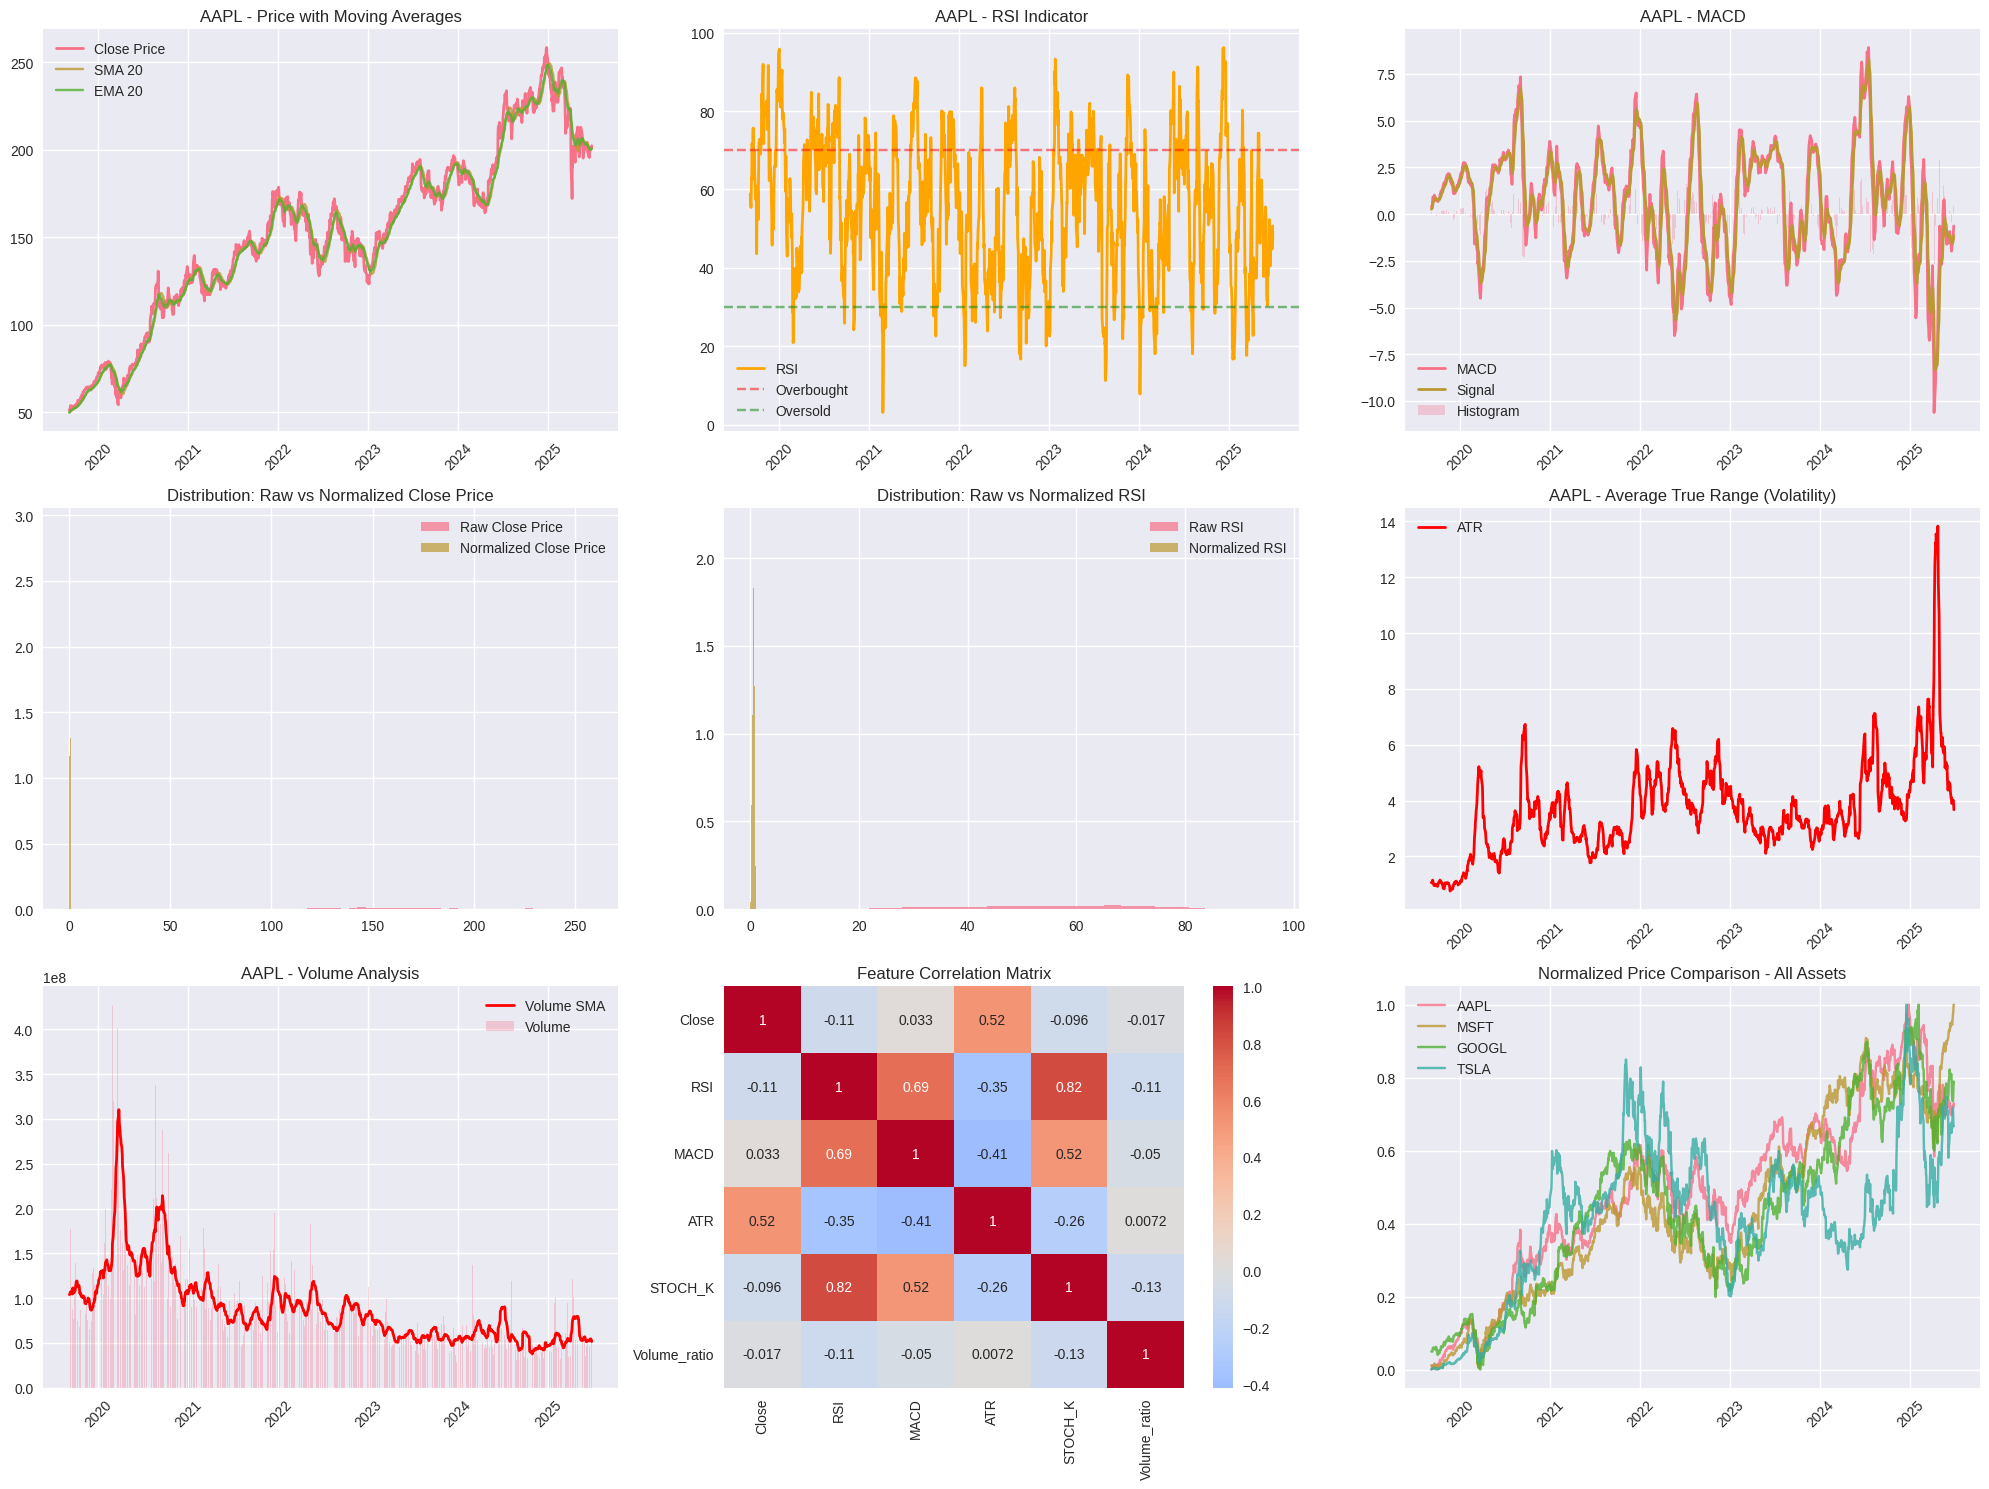


STEP 6: DETAILED ANALYSIS & SUMMARY
Dataset Summary:
------------------------------------------------------------

AAPL:
  Total samples: 1460
  Date range: 2019-09-06 to 2025-06-27
  Features: 30
  Missing values: 0
  Avg daily return: 0.0011
  Volatility (std): 0.0202
  Sharpe ratio: 0.0566

MSFT:
  Total samples: 1460
  Date range: 2019-09-06 to 2025-06-27
  Features: 30
  Missing values: 0
  Avg daily return: 0.0011
  Volatility (std): 0.0188
  Sharpe ratio: 0.0579

GOOGL:
  Total samples: 1460
  Date range: 2019-09-06 to 2025-06-27
  Features: 30
  Missing values: 0
  Avg daily return: 0.0009
  Volatility (std): 0.0202
  Sharpe ratio: 0.0461

TSLA:
  Total samples: 1460
  Date range: 2019-09-06 to 2025-06-27
  Features: 30
  Missing values: 0
  Avg daily return: 0.0030
  Volatility (std): 0.0424
  Sharpe ratio: 0.0707

Feature Engineering Summary:
------------------------------------------------------------
Trend: 5 indicators
Momentum: 6 indicators
Volatility: 5 indicators
Volum

In [7]:
## 5. VISUALIZATIONS
print("\n" + "="*50)
print("STEP 5: DATA VISUALIZATION")
print("="*50)

# Set up the plotting environment
fig = plt.figure(figsize=(20, 15))

# Choose primary asset for detailed visualization (AAPL)
primary_asset = 'AAPL'
df_viz = processed_data[primary_asset]['clean']
df_norm_viz = processed_data[primary_asset]['normalized']

# 1. Raw Price vs Technical Indicators
plt.subplot(3, 3, 1)
plt.plot(df_viz.index, df_viz['Close'], label='Close Price', linewidth=2)
plt.plot(df_viz.index, df_viz['SMA_20'], label='SMA 20', alpha=0.8)
plt.plot(df_viz.index, df_viz['EMA_20'], label='EMA 20', alpha=0.8)
plt.title(f'{primary_asset} - Price with Moving Averages')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(3, 3, 2)
plt.plot(df_viz.index, df_viz['RSI'], label='RSI', color='orange', linewidth=2)
plt.axhline(y=70, color='r', linestyle='--', alpha=0.5, label='Overbought')
plt.axhline(y=30, color='g', linestyle='--', alpha=0.5, label='Oversold')
plt.title(f'{primary_asset} - RSI Indicator')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(3, 3, 3)
plt.plot(df_viz.index, df_viz['MACD'], label='MACD', linewidth=2)
plt.plot(df_viz.index, df_viz['MACD_signal'], label='Signal', linewidth=2)
plt.bar(df_viz.index, df_viz['MACD_hist'], label='Histogram', alpha=0.3)
plt.title(f'{primary_asset} - MACD')
plt.legend()
plt.xticks(rotation=45)
# 2. Normalized vs Raw Data Distribution
plt.subplot(3, 3, 4)
plt.hist(df_viz['Close'], bins=50, alpha=0.7, label='Raw Close Price', density=True)
plt.hist(df_norm_viz['Close'], bins=50, alpha=0.7, label='Normalized Close Price', density=True)
plt.title('Distribution: Raw vs Normalized Close Price')
plt.legend()

plt.subplot(3, 3, 5)
plt.hist(df_viz['RSI'], bins=30, alpha=0.7, label='Raw RSI', density=True)
plt.hist(df_norm_viz['RSI'], bins=30, alpha=0.7, label='Normalized RSI', density=True)
plt.title('Distribution: Raw vs Normalized RSI')
plt.legend()

# 3. Volatility Analysis
plt.subplot(3, 3, 6)
plt.plot(df_viz.index, df_viz['ATR'], label='ATR', color='red', linewidth=2)
plt.title(f'{primary_asset} - Average True Range (Volatility)')
plt.legend()
plt.xticks(rotation=45)

# 4. Volume Analysis
plt.subplot(3, 3, 7)
plt.bar(df_viz.index, df_viz['Volume'], alpha=0.3, label='Volume')
plt.plot(df_viz.index, df_viz['Volume_SMA'], color='red', label='Volume SMA', linewidth=2)
plt.title(f'{primary_asset} - Volume Analysis')
plt.legend()
plt.xticks(rotation=45)

# 5. Correlation Heatmap
plt.subplot(3, 3, 8)
correlation_cols = ['Close', 'RSI', 'MACD', 'ATR', 'STOCH_K', 'Volume_ratio']
corr_matrix = df_viz[correlation_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
# 6. Multi-asset comparison
plt.subplot(3, 3, 9)
for symbol in processed_data.keys():
    df_temp = processed_data[symbol]['normalized']
    plt.plot(df_temp.index, df_temp['Close'], label=symbol, alpha=0.8)
plt.title('Normalized Price Comparison - All Assets')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## 6. DETAILED ANALYSIS & SUMMARY
print("\n" + "="*50)
print("STEP 6: DETAILED ANALYSIS & SUMMARY")
print("="*50)

# Performance metrics for each asset
print("Dataset Summary:")
print("-" * 60)
for symbol in processed_data.keys():
    df = processed_data[symbol]['clean']

    print(f"\n{symbol}:")
    print(f"  Total samples: {len(df)}")
    print(f"  Date range: {df.index[0].strftime('%Y-%m-%d')} to {df.index[-1].strftime('%Y-%m-%d')}")
    print(f"  Features: {len(df.columns)}")
    print(f"  Missing values: {df.isnull().sum().sum()}")

    # Basic statistics
    returns = df['Close'].pct_change().dropna()
    print(f"  Avg daily return: {returns.mean():.4f}")
    print(f"  Volatility (std): {returns.std():.4f}")
    print(f"  Sharpe ratio: {returns.mean()/returns.std():.4f}")
    # Feature importance analysis
print(f"\nFeature Engineering Summary:")
print("-" * 60)
feature_categories = {
    'Trend': ['SMA_20', 'SMA_50', 'EMA_20', 'MACD', 'MACD_signal'],
    'Momentum': ['RSI', 'STOCH_K', 'STOCH_D', 'Williams_R', 'CCI', 'ROC'],
    'Volatility': ['ATR', 'BB_upper', 'BB_lower', 'BB_width', 'BB_position'],
    'Volume': ['Volume_ratio', 'Volume_SMA'],
    'Price': ['Price_change', 'High_Low_ratio', 'Close_Open_ratio']
}

for category, features in feature_categories.items():
    print(f"{category}: {len(features)} indicators")

print(f"\nData Preprocessing Summary:")
print("-" * 60)
print("✓ Technical indicators calculated using pandas/numpy (no external dependencies)")
print("✓ Missing values handled (dropna)")
print("✓ MinMax normalization applied to price data")
print("✓ StandardScaler applied to technical indicators")
print("✓ Time-series aware train/validation/test split (70/15/15)")

print(f"\nVisualization Summary:")
print("-" * 60)
print("✓ Raw price vs technical indicators (SMA, EMA)")
print("✓ Momentum indicators (RSI, MACD)")
print("✓ Distribution comparison (raw vs normalized)")
print("✓ Volatility analysis (ATR)")
print("✓ Volume analysis with moving average")
print("✓ Feature correlation heatmap")
print("✓ Multi-asset normalized price comparison")


In [8]:
## 7. EXPORT FUNCTIONALITY
print("\n" + "="*50)
print("STEP 7: DATA EXPORT")
print("="*50)

# Save processed data
def save_processed_data(split_data, filename_prefix='processed_data'):
    """
    Save processed data to CSV files
    """
    for symbol in split_data.keys():
        for split_type in ['train', 'val', 'test']:
            # Save normalized data
            norm_filename = f"{filename_prefix}_{symbol}_{split_type}_normalized.csv"
            split_data[symbol][split_type]['normalized'].to_csv(norm_filename)

            # Save clean data
            clean_filename = f"{filename_prefix}_{symbol}_{split_type}_clean.csv"
            split_data[symbol][split_type]['clean'].to_csv(clean_filename)

        print(f"✓ Saved {symbol} data (train/val/test splits)")

# Uncomment to save data
# save_processed_data(split_data)
print("Data export functionality ready (uncomment save_processed_data call to use)")

## 8. ADVANCED FEATURES FOR DRL
print("\n" + "="*50)
print("STEP 8: ADVANCED FEATURES FOR DRL")
print("="*50)

def create_drl_features(df, lookback_window=20):
    """
    Create additional features specifically useful for DRL trading
    """
    data = df.copy()

    # 1. Price momentum features
    data['momentum_5'] = data['Close'].pct_change(5)
    data['momentum_10'] = data['Close'].pct_change(10)

    # 2. Volatility regime
    data['vol_regime'] = data['ATR'].rolling(20).mean() / data['ATR'].rolling(60).mean()

    # 3. Market state features
    data['trend_strength'] = abs(data['MACD'] - data['MACD_signal'])
    data['mean_reversion'] = (data['Close'] - data['SMA_20']) / data['ATR']

    # 4. Risk-adjusted returns
    data['risk_adj_return'] = data['Price_change'] / data['ATR']

    # 5. Relative performance
    data['relative_volume'] = data['Volume'] / data['Volume'].rolling(20).mean()

    return data

# Apply DRL features to primary asset
drl_features = create_drl_features(processed_data[primary_asset]['clean'])

print("Advanced DRL features created:")
print("✓ Multi-period momentum indicators")
print("✓ Volatility regime detection")
print("✓ Market state indicators")
print("✓ Risk-adjusted returns")
print("✓ Relative performance metrics")

print(f"\nFinal feature count for {primary_asset}: {len(drl_features.columns)}")

print("\n" + "="*50)
print("DATA PIPELINE COMPLETED SUCCESSFULLY!")
print("="*50)
print("Data collection: 4 stock assets with 6 years of data")
print("Feature engineering: 20+ technical indicators")
print("Data preprocessing: Normalization and cleaning")
print("Time-series split: Train/Val/Test (70/15/15)")
print("Comprehensive visualizations")
print("Advanced DRL features")
print("Export functionality")
print("\nThe dataset is now ready for DRL agent training!")


STEP 7: DATA EXPORT
Data export functionality ready (uncomment save_processed_data call to use)

STEP 8: ADVANCED FEATURES FOR DRL
Advanced DRL features created:
✓ Multi-period momentum indicators
✓ Volatility regime detection
✓ Market state indicators
✓ Risk-adjusted returns
✓ Relative performance metrics

Final feature count for AAPL: 37

DATA PIPELINE COMPLETED SUCCESSFULLY!
Data collection: 4 stock assets with 6 years of data
Feature engineering: 20+ technical indicators
Data preprocessing: Normalization and cleaning
Time-series split: Train/Val/Test (70/15/15)
Comprehensive visualizations
Advanced DRL features
Export functionality

The dataset is now ready for DRL agent training!
